Student name: David Schenck<br>
Student pace: Flex<br>
Scheduled project review date/time:<br>
Instructor Name: Morgan Jones<br>
Blog post URL:

# Project Description

The World Health Organization (WHO) estimates that 2 million children below the age of 5 die from pneumonia every year, making it the leading cause of child mortality worldwide. The vast majority of cases and deaths are in developing countries, particularly in Africa and Southeast Asia.

Timely diagnosis of pneumonia is key for improving health outcomes for patients. It is also important to determine whether the pneumonia is caused by a bacterial or a viral infection since the treatment plans are very different depending on the cause.

One effective method of diagnosing pneumonia is by taking chest X-rays. A medical expert can identify the telltale signs of pneumonia by observing the X-rays, but some facilities in developing countries lack such an expert. This slows down the process of diagnosing the disease, leading to delays in medical intervention.

A potential solution is to create a computer model that can interpret the chest X-rays. Such a model could be made available to medical facilities across the world, helping to shorten the time it takes to diagnose pediatric pneumonia so that life-saving treatment can be provided faster.

In this project, I train a convolutional neural network (CNN) to diagnose pneumonia using a labeled set of chest X-rays.

### Data
The data used in this project was obtained from https://data.mendeley.com/datasets/rscbjbr9sj/3.

The data contains 5856 images of chest X-rays taken for children 5 years of age or younger. The images were examined by 2 medical experts to determine whether the patient has pneumonia and, if so, whether it is bacterial or viral pneumonia. A third expert validated their classifications.

The data is split into train and test directories, and each of those is split into "NORMAL" and "PNEUMONIA" directories. The images corresponding to a patient with bacterial pneumonia all start with "BACTERIA" and those with viral pneumonia start with "VIRUS". Patients without pneumonia all of images starting with "NORMAL".

Below is a breakdown of how many images there are in each directory:

train - NORMAL: 1349<br>
train - PNEUMONIA: 3883 (BACTERIA: 2538, VIRUS: 1345)<br>
test - NORMAL: 234<br>
test - PNEUMONIA: 390 (BACTERIA: 242, VIRUS: 148)

In addition to indicating whether the patient has pneumonia, the filename also includes a unique 6-digit code for each patient and a 4-digit code counting the number of images for that patient since some patients have multiple images. For example, a patient with multiple images will have their first image will end with 0001, second with 0002, and so on.

The images have a variety of dimensions and aspect ratios. They are cropped and resized to a standard size before they are input to the CNN.

Note: The zip file provided at https://data.mendeley.com/datasets/rscbjbr9sj/3 contains data of both chest X-ray images for diagnosing pneumonia and optimal coherence tomography (OCT) images for diagnosing eye conditions. I only use the chest X-ray images.

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.utils import to_categorical
import os
import datetime
import matplotlib.pyplot as plt
from keras import regularizers
%matplotlib inline
plt.style.use('ggplot')

### Data Exploration

First, I just want to see how many images are in each directory

In [2]:
# Count the number of images in each directory
# Main directory
maindir = 'C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/'
# Subdirectories in main directory
subdirs = ['train/NORMAL/','train/PNEUMONIA/','test/NORMAL/','test/PNEUMONIA/']

for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        print(directory, '\t BACTERIA:',sum([1 if 'BACTERIA' in x else 0 for x in files]),
              'VIRUS:', sum([1 if 'VIRUS' in x else 0 for x in files]))
    else:
        print(directory, '\t \t NORMAL:', len(files))

train/NORMAL/ 	 	 NORMAL: 1349
train/PNEUMONIA/ 	 BACTERIA: 2538 VIRUS: 1345
test/NORMAL/ 	 	 NORMAL: 234
test/PNEUMONIA/ 	 BACTERIA: 242 VIRUS: 148


**Aspect Ratio**

The images have different dimensions and aspect ratios. I will crop and resize the images to a common size. Below, I determine what the average aspect ratio is. I will use this for the final aspect ratio.

In [3]:
# Get a list of all files
names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])] + \
        [os.path.join(maindir+subdirs[1], name) for name in os.listdir(maindir+subdirs[1])] + \
        [os.path.join(maindir+subdirs[2], name) for name in os.listdir(maindir+subdirs[2])] + \
        [os.path.join(maindir+subdirs[3], name) for name in os.listdir(maindir+subdirs[3])]

img_dims = []
for img_path in names:
    if 'jpeg' in img_path:
        img = load_img(img_path, color_mode='grayscale')
        img_dims.append([img.height,img.width])
img_dims = np.array(img_dims)

0.7147827266780963


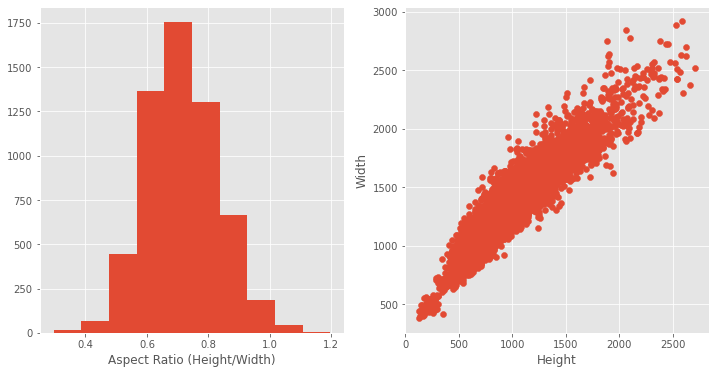

In [4]:
# Plot a histogram of aspect ratio and scatter plot of height and width
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

aspect_ratios = img_dims[:,0]/img_dims[:,1]
mean_aspect = np.mean(aspect_ratios)
print(mean_aspect)
ax[0].hist(aspect_ratios)
ax[0].set_xlabel('Aspect Ratio (Height/Width)')
ax[1].scatter(img_dims[:,0],img_dims[:,1])
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Width');

The mean aspect ratio is 0.715. I will use this aspect ratio when I create the tensors for use in the CNN models.

**Cropping and Resizing**

Below, I create a function that will read in an image, crop it, and resize it. The function also gives an option for rescaling, which is useful because CNN models tend to converge better if the values are between 0 and 1.

I could just resize without cropping, but this would result in stretching the image either vertically or horizontally if the aspect ratio is not equal to the aspect ratio of the desired dimensions. By cropping first, I avoid stretching the images.

The way I crop the images is by checking whether the image is too tall or too wide (compared to the average aspect ratio). If it is too tall, I will crop equal amounts from the top and bottom of the image to achieve the desired aspect ratio. If it is too wide, I crop equal amounts from the left and right. I tested this on a few images and the parts of images that get cut out should not be important for diagnosing pneumonia. The lungs are what matters and they don't get cropped out using the function below.

In [5]:
def crop_resize_image(filepath, dims=None, rescale=None):
    """
    Reads in an image, crops it, and resizes it so that the final array has dimensions dims.
    Input:
    filepath: Full directory path to image.
    dims: Desired dimensions of image as tuple. Default is None, in which case no cropping or resizing is done.
    rescale: Number by which to multiply the image. Default is to not rescale.
    """
    img = load_img(filepath, color_mode='grayscale')
    if dims == None:
        img_array = img_to_array(img)
    # Crop and resize if dims is specified
    else:
        desired_aspect = dims[0]/dims[1]
        if img.height/img.width > desired_aspect:
            desired_height = img.width * desired_aspect
            cut = np.round((img.height - desired_height)/2,0)
            img_crop = img.crop((0,cut,img.width,img.height-cut))
        else:
            desired_width = img.height / desired_aspect
            cut = np.round((img.width - desired_width)/2,0)
            img_crop = img.crop((cut,0,img.width-cut,img.height))
        img_resize = img_crop.resize((dims[1],dims[0]))
        img_array = img_to_array(img_resize)
        
    # Rescale the image if rescale is defined
    if rescale != None:
        img_array *= rescale
        
    return img_array[:,:,0]

In [6]:
# Try out the function above
directory = maindir + subdirs[0]
files = [x for x in os.listdir(directory) if 'jpeg' in x]
# Desired width of images
width = 180
# Dimensions use mean aspect ratio.
dimensions = (int(np.round(mean_aspect*width,0)), width)
img_array = crop_resize_image(directory+files[6], dimensions, 1/255)
img_array.shape

(129, 180)

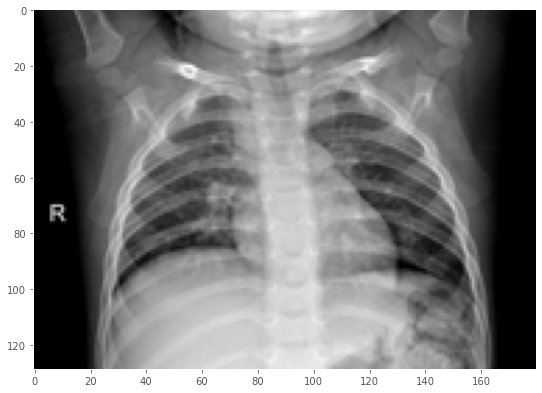

In [7]:
# Display an image after it has been cropped and resized
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(img_array, cmap='gray')
ax.grid(False)

The image above was cropped and resized to the desired dimensions. The image is not stretched or shrunk even though the original aspect ratio of the image might not have been the same as the final aspect ratio.

**Functions for Preparing Data**

The function below is used to get samples of images. The function allows the user to specify how many images to collect and whether you want one or two samples (useful for creating train and validation splits)

In [8]:
def get_image_filenames(rootdir, subdir, size='all', size2=0):
    """
    This function collects filenames of images.
    Input:
    rootdir: The directory that contains all of the data.
    subdir: Indicates whether to collect images from 'train' or 'test'.
    size: Number of images to collect. Default is collect all the images.
    size2: If indicated, it is the number of images to collect for a second sample.
        This is useful for creating a validation sample which won't overlap with the training sample.2
        
    Output:
    One list of files and one list of labels (if size2=0) or two lists of files and two lists of labels if size2>0.
    """
    # Get image names from NORMAL
    directory = rootdir + subdir + '/NORMAL/'
    files_normal = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    # Get image names from PNEUMONIA
    directory = rootdir + subdir + '/PNEUMONIA/'
    files_pneum = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    files_bacteria = [x for x in files_pneum if 'BACTERIA' in x]
    files_virus = [x for x in files_pneum if 'VIRUS' in x]

    # Check to make sure we did not ask for more files than exist in the directories
    if size != 'all':
        check = (len(files_normal) >= size+size2) * (len(files_bacteria) >= size+size2) * (len(files_virus) >= size+size2)
        if check == False:
            raise Exception('Asked for more images than are actually present')
    
    if size == 'all':
        filenames = np.append(files_normal, np.append(files_bacteria, files_virus))

        return filenames

    else:
        sample_normal = np.random.choice(files_normal, size+size2, replace=False)
        sample_bacteria = np.random.choice(files_bacteria, size+size2, replace=False)
        sample_virus = np.random.choice(files_virus, size+size2, replace=False)
            
        if size2 == 0:
            filenames = np.append(sample_normal, np.append(sample_bacteria, sample_virus))

            return filenames
        else:
            filenames1 = np.append(sample_normal[0:size], np.append(sample_bacteria[0:size],sample_virus[0:size]))
            filenames2 = np.append(sample_normal[size:], np.append(sample_bacteria[size:],sample_virus[size:]))

            return filenames1, filenames2

In [9]:
def create_tensors(filenames, dims, OHE=True):
    """
    Function for turning a list of filenames into tensors that can be input to a CNN model.
    Inputs:
    filenames: List of filenames.
    dims: The desired dimensions of the output.
    OHE: Indicates whether the class labels should be one-hot encoded. Default is True.
    """
    x = np.zeros((len(filenames), dims[0], dims[1]))
    y = np.zeros(len(filenames))

    # Loop over files
    for n, file in enumerate(filenames):
        x[n] = crop_resize_image(file, dims, 1/255)
        # Determine the class of the image
        if 'NORMAL' in file:
            y[n] = 0
        elif 'BACTERIA' in file:
            y[n] = 1
        elif 'VIRUS' in file:
            y[n] = 2
        else:
            raise Exception(f"Cannot determine class for {file}")

    # One-hot encode the classes if OHE is True
    if OHE:
        y = to_categorical(y, 3)

    # Reshape x into a tensor
    x = x.reshape(-1, dims[0], dims[1], 1)
    return x, y

Below, I use the functions I have written to create train, validation, and test samples.

In [55]:
# Set random seed
np.random.seed(42)
# Size of train dataset
train_size = 500
# Size of validation dataset
val_size = 100

# Desired width of images
width = 240
# Dimensions use mean aspect ratio.
dimensions = (int(np.round(mean_aspect*width,0)), width)

# Get list of images for train and validation
train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

# Get list of images for test
test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

# Create tensors for train, validation, and test
x_train, y_train = create_tensors(train_list, dimensions, OHE=True)
x_val, y_val = create_tensors(val_list, dimensions, OHE=True)
x_test, y_test = create_tensors(test_list, dimensions, OHE=True)

In [11]:
# Import modules needed for creating a CNN model
from keras import models
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### Building a Convolutional Neural Network

I am going to iteratively create a convolutional neural network. In order to evaluate the models, I need to look at some metrics. It will be helpful to have a function I can call that will display the metrics I care about.

The function below will create and print a classification report, a confusion matrix, and ROC curves. Since there are three classes, three ROC curves are created by considering one class vs. the others. Classification reports and confusion matrices will be created for train, validation, and test datasets. ROC curves will only be created for the test dataset.

In [12]:
def display_metrics(model, train_data=None, val_data=None, test_data=None):
    """
    Function for displaying classification reports, confusion matrices, and ROC curves.
    Classification reports and confusion matrices are created for train, validation, and test data.
    ROC curves are only created for the test data.
    
    Inputs:
    model: The fitted model.
    train_data, val_data, test_data: (x,y) tuple containing different types of data.
    Default is None, in which case no classification report or confusion matrix will be displayed.
    
    """
    # Classification reports
    
    count = 0
    
    if train_data != None:
        print("Classification Report: Train")
        print(classification_report(np.argmax(train_data[1], axis=-1),
                                    np.argmax(model.predict(train_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if val_data != None:
        print("Classification Report: Validation")
        print(classification_report(np.argmax(val_data[1], axis=-1),
                                    np.argmax(model.predict(val_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if test_data != None:
        print("Classification Report: Test")
        print(classification_report(np.argmax(test_data[1], axis=-1),
                                    np.argmax(model.predict(test_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
        
    # Confusion Matrices
    fig, ax = plt.subplots(ncols=count, figsize=(count*5,4))
    n = 0
    if train_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(train_data[1], axis=-1), np.argmax(model.predict(train_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_train = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Train')
        ax[n].grid(False)
        n += 1
    if val_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(val_data[1], axis=-1), np.argmax(model.predict(val_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_val = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Validation')
        ax[n].grid(False)
        n += 1
    if test_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(test_data[1], axis=-1), np.argmax(model.predict(test_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_test = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Test')
        ax[n].grid(False)

    fig.tight_layout()
    
    # Print binary accuracy (healthy vs. pneumonia)
    print('Binary Accuracy')
    print('Train:', round(acc_train,3))
    print('Validation:', round(acc_val,3))
    print('Test:', round(acc_test,3))
    
    # ROC curves (only test data)
    if test_data != None:
        fig2, ax2 = plt.subplots(figsize=(6,6))
        
        ax2.plot([0,1],[0,1])
        
        for i, case in enumerate(['NORMAL vs. Rest','BACTERIA vs. Rest','VIRUS vs. Rest']):
            fpr, tpr, thresh = roc_curve(test_data[1][:,i], model.predict(test_data[0])[:,i])
            ax2.plot(fpr, tpr, label=f"{case}: {round(auc(fpr, tpr),3)}")
        ax2.set_title('ROC Curve: Test Data')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()

I also created a function for displaying the loss and accuracy as a function of epoch.

In [16]:
def plot_history(history):
    """
    Function to plot the loss and accuracy vs epoch for a model.
    Input is the history of a model.
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch = range(len(acc))
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax[0].plot(epoch, acc, label='Training')
    ax[0].plot(epoch, val_acc, label='Validation')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(epoch, loss, label='Training')
    ax[1].plot(epoch, val_loss, label='Validation')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

**Iteratively Making a Model**

The way I am going to create the model is by running a model, evaluating its performance, than changing one aspect of that model for the next iteration, that way I can understand what difference that one change made. As a result, I may end up trying quite a few models. I do not want the notebook to have to rerun every single model I try when I run the notebook, so instead I will summarize the results of each model in the table in the cell below. Only the final model will be included in the final notebook, but the performance of each model will be present in the table.

### Evaluation

The table below summarizes the performance of each model.<br>
The Description column says which model was changed and how to create a new model. For example, if the table says Model 4 is "3 + L2 regularization", it means that Model 4 is exactly the same as Model 3 except it uses L2 regularization.

Model 1 is described in detail below:<br>
**Input**: The input is a tensor with 1500 images that have been downsampled to 129x180. There are 500 of each class. The correct class labels are input as one-hot encode arrays.<br>
**Layers**: The model contains 4 Conv2D layers. Each layer uses a 3x3 kernel. The number of filters in each Conv2D layer are 32, 32, 64, and 128. After each Conv2D layer is a MaxPooling2D layer to downsample the images using a 2x2 kernel. This reduces the sizes of the images. After the 4 Conv2D-MaxPooling2D layers, there is a Flatten layer, a Dense layer with 128 nodes, then finally the output Dense layer with three nodes (one per class). The activation function is 'relu' for every layer except the output layer which uses 'softmax'.<br>
**Regularization**: The first model uses no regularization or Dropout layers.<br>
**optimizer**: SGD.<br>
**epochs**: 80.<br>
**batch_size**: 30.<br>
**loss function**: categorical_crossentropy. This will not change for any of the models.


|Version |Description |Train Accuracy |Binary Train Accuracy |Test Accuracy |Binary Test Accuracy |Recall (healthy) |Recall (bacterial) |Recall (viral) |AUC (healthy) |AUC (bacterial) |AUC (viral) |time (s) |
|-----|-----------------------|--------|--------|-------|-------|-------|-------|--------|-------|-------|--------|-------|
|1    |Baseline               |89.1%   |97.7%   |73.4%  |87.7%  |75.6%  |62.8%  |87.2%   |0.945  |0.935  |0.896   |1257   |
|2    |1 + RMSprop optimizer  |100%    |100%    |78.5%  |92.9%  |85.0%  |74.0%  |75.7%   |0.97   |0.924  |0.888   |1217   |
|3    |2 + Dropout layers     |99.9%   |100%    |83.7%  |93.6%  |89.3%  |83.9%  |74.3%   |0.971  |0.934  |0.917   |1372   |
|4    |3 + L2 regularization  |82.7%   |96.1%   |81.7%  |90.9%  |82.1%  |84.7%  |76.4%   |0.957  |0.938  |0.906   |1420   |
|5    |4 remove a layer       |86.5%   |96.9%   |82.2%  |91.5%  |85.9%  |79.3%  |81.1%   |0.951  |0.932  |0.913   |1271   |
|6    |5 input is 172x240     |94.5%   |98.5%   |81.2%  |93.1%  |87.6%  |72.7%  |85.1%   |0.962  |0.927  |0.902   |2376   |

Descriptions:<br>
**Model 1**: The first model achieved decent accuracy on the test data (73.4%), but there is definitely room for improvement. The model did overfit a bit as the accuracy on the training data was 89.1%. The model appeared to start overfitting a little before epoch 50. The model performed the worst on the bacterial pneumonia images (62.8% recall). This is one metric I really want to improve.<br>
Before I start addressing the overfitting, I want to test out other optimizers.

**Model 2**: This model is the same as Model 1, but uses the RMSprop optimizer instead of SGD.<br>
This model overfit much more than Model 1; the accuracy on training data was 100%. Despite the overfitting, the performance on the test data did improve. The accuracy was about 5% higher on both overall accuracy and binary accuracy. The recall improved by around 10% for both healthy and bacterial pneumonia images, but the performance on viral images got worse.
If I can address the overfitting in this model without degrading the performance too much, that would be ideal.

**Model 3**: This model is Model 2, but with Dropout layers after each Conv2D-MaxPooling2D layer. There is also a Dropout layer after the first Dense layer. The Dropout layers are set to drop 20% each time.<br>
The presence of the Dropout layers barely reduced the overfitting. The overall accuracy was nearly 100% instead of actually being 100%. The good news is that the overall performance on the test data did improve. The accuracy went up another 5% and the binary accuracy got a little higher.<br>
Next, I will iterate on this model using regularization to try to reduce the overfitting further.

**Model 4**: This model is Model 3, but it uses L2 regularization (with a value of 0.005) on the Conv2D layers and the first Dense layer. I am still keeping the Dropout layers.<br>
The overfitting has been eliminated. Throughout the entire 80 epochs, the accuracy of the test data did not deviate much from the accuracy on the train data. The overall performance on the test data is a little worse (overall accuracy down 2% from Model 3).

**Model 5**: This model reduces the depth of the network by removing the Conv2D layer that has 128 filters and reduces the number of nodes in the first dense layer from 128 to 64. Counterintuitively, this model actually has more trainable parameters than the last because it also gets rid of one MaxPooling2D layer, which means it does not reduce the image size as much.<br>
This model outperformed Model 4 in both overall accuracy and binary accuracy (though by a small amount). It is overfitting a little, but it is not nearly as severe as Model 2 or 3.

**Model 6**: This model is the same as Model 5, except that the input images are 172x240 instead of 129x180. The increase in resolution unsurprisingly makes the model take longer. If I am going to use higher resolution images in my final model, they better increase the performance significantly.<br>
The model did not seriously improve over Model 5. While the binary accuracy did increase, the overall accuracy actually decreased by 1% and the performance on bacterial pneumonia cases got worse. This sort of performance does not justify almost doubling the training time.

**Model 7**: 

In [56]:
# Create the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                        input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.005)))

model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 170, 238, 32)      320       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 85, 119, 32)       0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 85, 119, 32)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 83, 117, 32)       9248      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 41, 58, 32)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 41, 58, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 39, 56, 64)      

In [57]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=80,
                    batch_size=30,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/80
50/50 [==============================] - 28s 570ms/step - loss: 1.6678 - acc: 0.3720 - val_loss: 1.3145 - val_acc: 0.5067
Epoch 2/80
50/50 [==============================] - 29s 584ms/step - loss: 1.1469 - acc: 0.5580 - val_loss: 1.0286 - val_acc: 0.6200
Epoch 3/80
50/50 [==============================] - 29s 583ms/step - loss: 0.9559 - acc: 0.6107 - val_loss: 0.9172 - val_acc: 0.6600
Epoch 4/80
50/50 [==============================] - 29s 583ms/step - loss: 0.8885 - acc: 0.6580 - val_loss: 0.8220 - val_acc: 0.7100
Epoch 5/80
50/50 [==============================] - 29s 588ms/step - loss: 0.8795 - acc: 0.6593 - val_loss: 0.8945 - val_acc: 0.6433
Epoch 6/80
50/50 [==============================] - 30s 592ms/step - loss: 0.8384 - acc: 0.6607 - val_loss: 0.8095 - val_acc: 0.7167
Epoch 7/80
50/50 [==============================] - 29s 585ms/step - loss: 0.8128 - acc: 0.6753 - val_loss: 0.7993 - val_acc: 0.7100
Epoch 8/80
50/50 [==============================] - 29s 586ms/step - 

50/50 [==============================] - 29s 589ms/step - loss: 0.5872 - acc: 0.8180 - val_loss: 0.7994 - val_acc: 0.7067
Epoch 63/80
50/50 [==============================] - 28s 563ms/step - loss: 0.5825 - acc: 0.8247 - val_loss: 0.9302 - val_acc: 0.6500
Epoch 64/80
50/50 [==============================] - 28s 569ms/step - loss: 0.5668 - acc: 0.8333 - val_loss: 0.7869 - val_acc: 0.7467
Epoch 65/80
50/50 [==============================] - 29s 570ms/step - loss: 0.5636 - acc: 0.8293 - val_loss: 0.8432 - val_acc: 0.7467
Epoch 66/80
50/50 [==============================] - 29s 585ms/step - loss: 0.5695 - acc: 0.8300 - val_loss: 0.7630 - val_acc: 0.7667
Epoch 67/80
50/50 [==============================] - 28s 566ms/step - loss: 0.5675 - acc: 0.8347 - val_loss: 0.7942 - val_acc: 0.7433
Epoch 68/80
50/50 [==============================] - 28s 561ms/step - loss: 0.5721 - acc: 0.8367 - val_loss: 0.8238 - val_acc: 0.7233
Epoch 69/80
50/50 [==============================] - 28s 569ms/step - loss

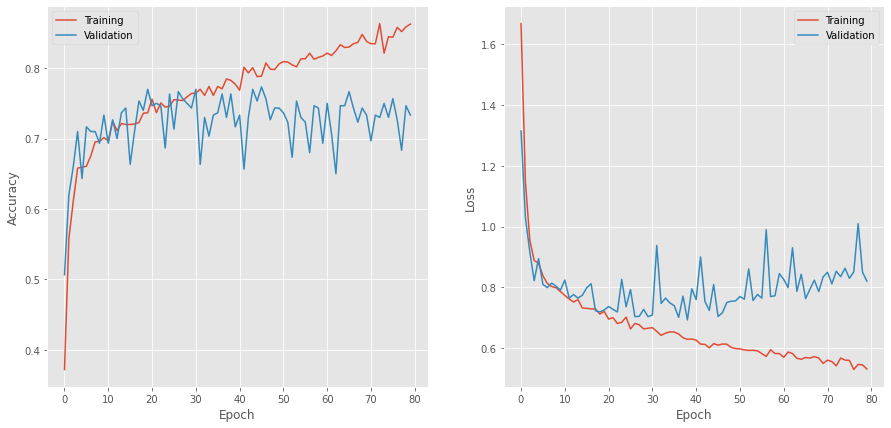

In [58]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.969     0.988     0.978       500
    BACTERIA      0.964     0.904     0.933       500
       VIRUS      0.906     0.944     0.925       500

    accuracy                          0.945      1500
   macro avg      0.946     0.945     0.945      1500
weighted avg      0.946     0.945     0.945      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.870     0.940     0.904       100
    BACTERIA      0.696     0.640     0.667       100
       VIRUS      0.620     0.620     0.620       100

    accuracy                          0.733       300
   macro avg      0.729     0.733     0.730       300
weighted avg      0.729     0.733     0.730       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.936     0.876     0.905       234
    BACTERIA      0.880     0.727     

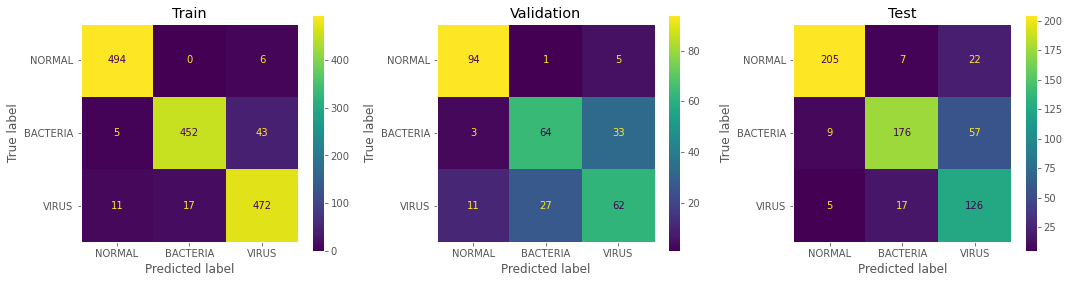

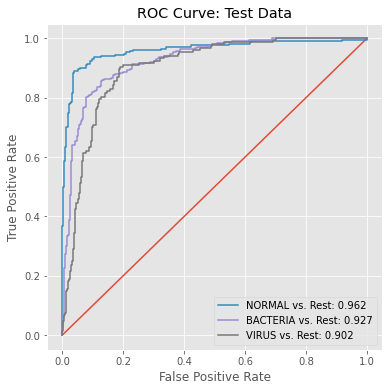

In [59]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

Things I can adjust to improve the model:

Change input:
Change size of input image
Change number of input images used

Change architecture:
Add/subtract layers
Increase number of filters/nodes in a layer
Change optimizer

Model:
Change number of epochs
Change batch size

Regularization:
Add kernel regularization
Add dropout layers